In [2]:
import torch
from diffusers import DDPMParallelScheduler
from diffusers import StableDiffusionParadigmsPipeline

scheduler = DDPMParallelScheduler.from_pretrained("/mnt/petrelfs/songmingyang/songmingyang/model/mm/diffusers/stable-diffusion-v1-5", subfolder="scheduler")

pipe = StableDiffusionParadigmsPipeline.from_pretrained(
    "/mnt/petrelfs/songmingyang/songmingyang/model/mm/diffusers/stable-diffusion-v1-5", scheduler=scheduler, torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

ngpu, batch_per_device = torch.cuda.device_count(), 5
pipe.wrapped_unet = torch.nn.DataParallel(pipe.unet, device_ids=[d for d in range(ngpu)])

prompt = "a photo of an astronaut riding a horse on mars"


/mnt/petrelfs/songmingyang/anaconda3/envs/smoe/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


In [3]:
image = pipe(prompt, parallel=ngpu * batch_per_device, num_inference_steps=50).images[0]

100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


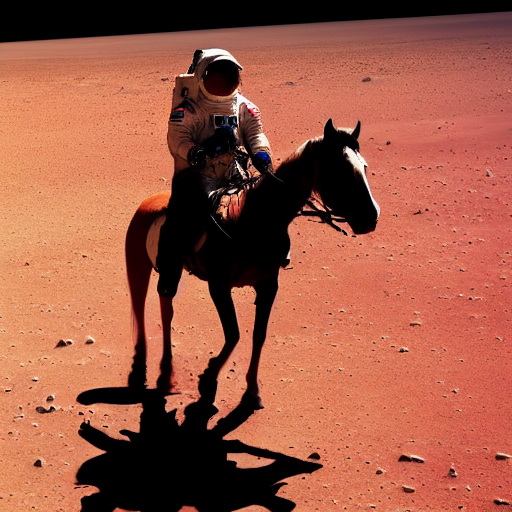

In [4]:
image

In [9]:
# 统计 FLOPs
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    with_flops=True,  # 启用 FLOPs 统计
    record_shapes=True,
    with_stack=True
) as prof:
     image = pipe(prompt, parallel=ngpu * batch_per_device, num_inference_steps=20).images[0]
total_flops = sum(event.flops for event in prof.key_averages() if event.flops is not None)
print(f"Total FLOPs: {convert_to_human_readable_size(total_flops)}")
# 打印统计结果
# print(prof.key_avera“”ges().table(sort_by="cuda_time_total", row_limit=10))

STAGE:2025-01-31 13:16:41 11850:11850 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
100%|██████████| 20/20 [00:02<00:00,  9.85it/s]
STAGE:2025-01-31 13:16:45 11850:11850 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-01-31 13:16:45 11850:11850 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Total FLOPs: 90.72 T


In [10]:
balance = 581745
aug = 665298
real_flops =  total_flops * (aug-balance)
print(f"real flops:{convert_to_human_readable_size(real_flops)}")

real flops:7.58 E


In [11]:
balance = 1168639
aug = 1246901
real_flops =  total_flops * (aug-balance)
print(f"real flops:{convert_to_human_readable_size(real_flops)}")

real flops:7.10 E


In [6]:
def convert_to_human_readable_size(num):
    if num / 1e18 > 1:
        return f"{num / 1e18:.2f} E"
    elif num / 1e15 > 1:
        return f"{num / 1e15:.2f} P"
    elif num / 1e12 > 1:
        return f"{num / 1e12:.2f} T"
    elif num / 1e9 > 1:
        return f"{num / 1e9:.2f} B"
    elif num / 1e6 > 1:
        return f"{num / 1e6:.2f} M"
    elif num / 1e3 > 1:
        return f"{num / 1e3:.2f} K"
    else:
        return f"{num}"

In [16]:
convert_to_human_readable_size(6999885565952)

'7.00 T'

In [17]:
## Control
from types import SimpleNamespace
@dataclass
class DataArguments:
    input_path: str = field(default_factory=str)
    img_dir_path: str = field(default=None)
    output_path: str = field(default=None)
    batch_size: int = field(default=1)
    num_workers: int = field(default=2)
    detect_resolution: int = field(default=512)
    image_resolution: int = field(default=512)
    
    
    
@dataclass
class InferenceArguments:
    model_config_path: str = field(default="/mnt/petrelfs/songmingyang/code/mm/robustLMM/ref/ControlNet/models/cldm_v15.yaml")
    model_ckpt_path: str = field(default="/mnt/petrelfs/songmingyang/songmingyang/model/mm/diffusers/ControlNet/models/control_sd15_hed.pth")
    seed: int = field(default=42)
 
# 假设你的参数是一个字典
data_args_dict = {
    "input_path":"/mnt/petrelfs/songmingyang/songmingyang/data/llava_train/LLaVA-Instruct-150K/reformed_data/statistics/llavaft_toaug.jsonl",
    "image_dir_path": "/mnt/petrelfs/songmingyang/songmingyang/data/mm/imgs",
    "output_path": "/mnt/petrelfs/songmingyang/songmingyang/data/mm/imgs/llava_aug/controlaug"
    "batch_size":1,
    "num_workers":2,
    "detect_resolution":512,
    "image_resolution":512,
}

inference_args_dict = {
    "model_config_path": "/mnt/petrelfs/songmingyang/code/mm/robustLMM/ref/ControlNet/models/cldm_v15.yaml",
    "model_ckpt_path": "/mnt/petrelfs/songmingyang/songmingyang/model/mm/diffusers/ControlNet/models/control_sd15_hed.pth"
}

# 将字典转换为支持点访问的对象
data_args = SimpleNamespace(**data_args_dict)
inference_args = SimpleNamespace(**inference_args_dict)

In [ ]:
class ControlnetInference():
    def __init__(self,data_args,inference_args) -> None:
        self.data_args = data_args
        self.inference_args = inference_args
        self.model_config_path = self.inference_args.model_config_path
        self.model_ckpt_path = self.inference_args.model_ckpt_path
        self.detect_resolution = data_args.detect_resolution
        self.image_resolution = data_args.image_resolution
        
        self.accelerator = Accelerator()
        
        self.hyper_dict = dict(
                    input_image=None,
                    prompt="default",
                    a_prompt="best quality, extremely detailed",
                    n_prompt="longbody, lowres, bad anatomy, bad hands, bad faces, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, art, cartoon",
                    num_samples=1,
                    image_resolution=data_args.image_resolution,
                    detect_resolution=data_args.detect_resolution,
                    ddim_steps=20,
                    guess_mode=False,
                    strength=1.0,
                    scale=9.0,
                    seed=inference_args.seed,
                    eta=0.0,
                )
        
        self.init_model()
        self.init_data()
    
    def init_data(self):
        self.dataset = ControlnetGenerationDataset(self.data_args)
        self.dataloader = DataLoader(self.dataset,
                                     collate_fn=DataCollatorForDiffusionGenerationDataset(),
                                     batch_size=self.data_args.batch_size,
                                     num_workers=self.data_args.num_workers,)
        assert self.data_args.batch_size == 1, "batch_size must be 1"
        
        
    
    def init_model(self):
        model = create_model(self.model_config_path).cpu()
        model.load_state_dict(load_state_dict(self.model_ckpt_path, location='cpu'))
        self.model = model
        
        self.model.eval()
        self.model = self.model.to(self.accelerator.device)
        self.ddim_sampler = DDIMSampler(self.model)
        
        self.apply_hed = HEDdetector_accelerator(self.accelerator)
        
    
    def process(self):
        
        
        self.dataloader = self.accelerator.prepare(self.dataloader)
        
        seed = self.hyper_dict["seed"]
        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)
        with torch.no_grad():    
            for batch in tqdm(self.dataloader):
                image = batch["images"][0]
                id = batch["ids"][0]
                
                try:
                    detected_map = self.apply_hed(resize_image(image, self.detect_resolution))
                    detected_map = HWC3(detected_map)
                    
                    H, W, C = image.shape
                    input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta \
                    = image, self.hyper_dict["prompt"], self.hyper_dict["a_prompt"], self.hyper_dict["n_prompt"], self.hyper_dict["num_samples"], self.hyper_dict["image_resolution"], self.hyper_dict["detect_resolution"], self.hyper_dict["ddim_steps"], self.hyper_dict["guess_mode"], self.hyper_dict["strength"], self.hyper_dict["scale"], self.hyper_dict["seed"], self.hyper_dict["eta"]

                    
                    control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
                    control = torch.stack([control for _ in range(num_samples)], dim=0)
                    control = einops.rearrange(control, 'b h w c -> b c h w').clone()

                    

                    if config.save_memory:
                        self.model.low_vram_shift(is_diffusing=False)

                    cond = {"c_concat": [control], "c_crossattn": [self.model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
                    un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [self.model.get_learned_conditioning([n_prompt] * num_samples)]}
                    shape = (4, H // 8, W // 8)
                    
                    if config.save_memory:
                        self.model.low_vram_shift(is_diffusing=True)

                    self.model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
                    samples, intermediates = self.ddim_sampler.sample(ddim_steps, num_samples,
                                                                shape, cond, verbose=False, eta=eta,
                                                                unconditional_guidance_scale=scale,
                                                                unconditional_conditioning=un_cond)

                    if config.save_memory:
                        self.model.low_vram_shift(is_diffusing=False)

                    x_samples = self.model.decode_first_stage(samples)
                    x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

                    results = [x_samples[i] for i in range(num_samples)]
                    self.dataset.write_item({"id":id,"results":results})
                except Exception as e:
                    print(f"Error in {id}")
                    print(e)
                    continue
                
                
                